In [1]:
import numpy as np                                                    # Packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from scipy.ndimage import gaussian_filter1d
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
from scipy.sparse import csr_matrix
import scipy.io
from scipy.sparse import coo_matrix
import numpy as np
from decimal import Decimal, getcontext

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_6_curated.zip')

/tmp/ipykernel_1394529/2822876284.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_6_curated.zip')


In [3]:
sd.N

59

In [4]:
sd.train

[array([3.2850000e+01, 6.1400000e+01, 8.1150000e+01, ..., 1.1993215e+05,
        1.1995670e+05, 1.1997525e+05]),
 array([   746.75,   1030.25,   1966.  ,   2193.2 ,   2937.55,   3033.75,
          3189.6 ,   3437.25,   3734.8 ,   4328.8 ,   4574.05,   4910.  ,
          4932.45,   5274.3 ,   5488.7 ,   5869.7 ,   6056.3 ,   6299.55,
          6592.8 ,   6839.7 ,   7291.4 ,   7685.9 ,   8312.1 ,   8922.65,
          9023.3 ,   9301.6 ,   9617.85,   9687.55,   9881.75,  10129.35,
         10629.4 ,  11003.45,  12404.45,  12894.75,  13160.  ,  13264.25,
         13435.8 ,  13646.15,  13804.05,  14118.05,  14317.3 ,  14591.1 ,
         15367.9 ,  15487.05,  15504.35,  15871.55,  16046.2 ,  16184.25,
         16234.4 ,  16378.45,  16574.1 ,  17066.95,  17277.8 ,  17368.85,
         17622.15,  17723.05,  18510.8 ,  18771.85,  18991.85,  19122.65,
         20400.2 ,  20573.15,  20862.85,  20905.95,  21554.75,  22278.  ,
         22544.3 ,  22824.1 ,  22855.55,  22877.35,  22890.25,  22898.6 ,

In [5]:
s_train = sd.train

In [6]:
neural_unit_index = []
spike_times = []

In [7]:
for index, array in enumerate(s_train):
    neural_unit_index.extend([index] * len(array))
    spike_times.extend(array)
    
result_array = np.column_stack((neural_unit_index, spike_times))

In [8]:
result_array[:,1] /= 1000

In [9]:
result_array[:, 0] += 1

In [10]:
result_array.shape

(26625, 2)

In [11]:
len(np.unique(result_array[:, 0]))

59

In [12]:
import scipy.io as sio
import os

In [23]:
current_directory = os.getcwd()

# Provide the file name for the .mat file
file_name = "Human_Data.mat"
file_full_path = os.path.join(current_directory, file_name)

# Create a dictionary to store the numpy array with a specific variable name
data_to_save = {"Human_Data": result_array}

# Save the dictionary to a .mat file
sio.savemat(file_full_path, data_to_save)

In [13]:
def createFCM(spksExc, spksInh=None):    
    
    # time constant of exponential profile (used for coupling)
    tau = 3e-3

    # 1e-4 binless window step in seconds
    step = 1e-4
    
    # store ids of neurons that really fired -- corresponding to entries in
    # adjacency relation
    
    if spksInh is None:
        old_ids = np.unique(spksExc[:, 0])
        spks = np.column_stack((spksExc, np.ones(len(spksExc))))
    else:
        old_ids = np.unique(np.concatenate((spksExc[:, 0], spksInh[:, 0])))
        spks = np.row_stack((np.column_stack((spksExc, np.ones(len(spksExc)))), 
                             np.column_stack((spksInh, -np.ones(len(spksInh))))))
        
    Eneuron_end = np.max(spksExc[:, 0])
    num_neurons = len(old_ids)
    
    row_indices = old_ids - 1  # Since Python uses 0-based indexing, we subtract 1 from old_ids
    col_indices = np.zeros_like(row_indices)
    values = np.arange(1, num_neurons + 1)

    new_ids = coo_matrix((values, (row_indices, col_indices)), shape=(num_neurons, 1))
    
    # frequency of spiking for individual neurons
    spike_freq = np.zeros(num_neurons)
    
    # duration of spike trains
    t_min = 0
    t_max = np.max(spksExc[:,1])
    T = t_max - t_min
    sig_length = np.ceil(T/step).astype(int)
    
    # Convert the new_ids sparse matrix to a dense NumPy array
    new_ids_array = new_ids.toarray().flatten()

    print(Eneuron_end)

    # Get spiking frequencies
    spike_freq = np.zeros(num_neurons)

    for i in range(1, num_neurons + 1):
        if i <= Eneuron_end:
            neuron_spikes = spksExc[spksExc[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
        else:
            if spksInh is None:
                print("spksInh is None. Make sure it is properly defined.")
                return None
                
            neuron_spikes = spksInh[spksInh[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
            
    # create signals for each neuron        
    signals = np.zeros((num_neurons, sig_length))
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        IorE = np.unique(spks[spks[:, 0] == k, 2])
        # how neuron i will influence other neurons
        signals[i - 1, :] = create_signal(spks[spks[:, 0] == k, 1], step, sig_length, tau, IorE)
    
    FC_MAT = np.zeros((num_neurons, num_neurons))
    spike_vecs = np.zeros((num_neurons, sig_length))

    # Previous code up to combining with discrete spiking events...

    # Combine with discrete spiking events
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        spike_times = spks[spks[:, 0] == k, 1]
        spike_times_vec = coo_matrix((np.ones_like(spike_times), 
                                      (np.ceil(spike_times / step).astype(int) - 1, 
                                       np.zeros_like(spike_times))), 
                                     shape=(sig_length, 1)).toarray().flatten()
        spike_vecs[i - 1, :] = spike_times_vec
        # Influence on neuron i from all other neurons.
        FC_MAT[:, i - 1] = signals.dot(spike_times_vec)

    # Thresholding
    FC_MAT[FC_MAT < 0] = 0
    FC_MAT = FC_MAT - np.diag(np.diag(FC_MAT))

    # Frequency normalization
    freq_normalization = spike_freq / np.maximum(spike_freq, 1)  # Divide element-wise with maximum value of 1
    freq_normalization[freq_normalization > 1] = 1

    FC_MAT = FC_MAT * freq_normalization

    return FC_MAT

In [14]:
def create_signal(start_times, dt, sig_length, tau, mode):
    # time vector
    t_vec = np.arange(dt, (sig_length + 1) * dt, dt)

    q = np.zeros_like(t_vec)

    if mode == 1:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq
    else:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            qq = 1 - qq
            qq[qq > 0.99] = 0  # corresponds to ~4.5 tau
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq

    # due to rounding of spiking times, the exponential may sometimes not start at 1
    if mode == 1:
        idx = np.ceil(start_times / dt).astype(int) - 1
        idx = np.clip(idx, 0, len(q) - 1)  # Clip indices to be within valid range
        q[idx] = 1

    # shift to zero mean and make magnitude normalized
    q = q - np.mean(q)
    q = q / (np.max(q) * len(start_times))

    return q

In [15]:
FC_MAT = createFCM(result_array)

59.0


/tmp/ipykernel_1394529/3072996499.py:9: RuntimeWarning: overflow encountered in exp
  qq = np.exp(-(t_vec - start_times[k]) / tau)


KeyboardInterrupt: 

In [17]:
FC_MAT

array([[0.        , 0.        , 0.00276831, ..., 0.        , 0.        ,
        0.00045705],
       [0.00490294, 0.        , 0.00100146, ..., 0.        , 0.0058181 ,
        0.        ],
       [0.0300288 , 0.        , 0.        , ..., 0.00051975, 0.01027648,
        0.00036457],
       ...,
       [0.        , 0.01883247, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00206113, 0.        , 0.        , ..., 0.00118709, 0.        ,
        0.        ],
       [0.00068901, 0.        , 0.00480187, ..., 0.        , 0.00911224,
        0.        ]])

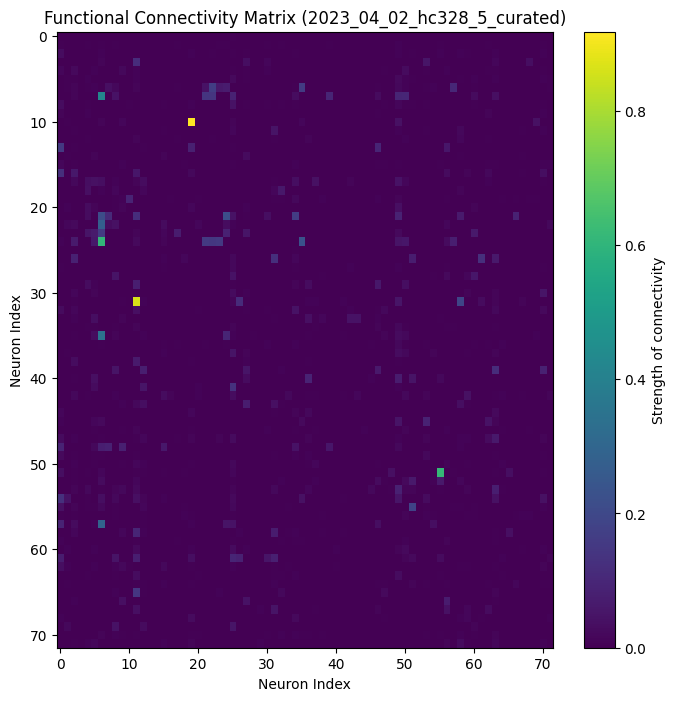

In [22]:
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
heatmap = plt.imshow(FC_MAT, cmap='viridis', aspect='auto')
colorbar = plt.colorbar(heatmap)  # Add a colorbar for better interpretation
colorbar.set_label('Strength of connectivity')  # Add the label to the colorbar
plt.title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

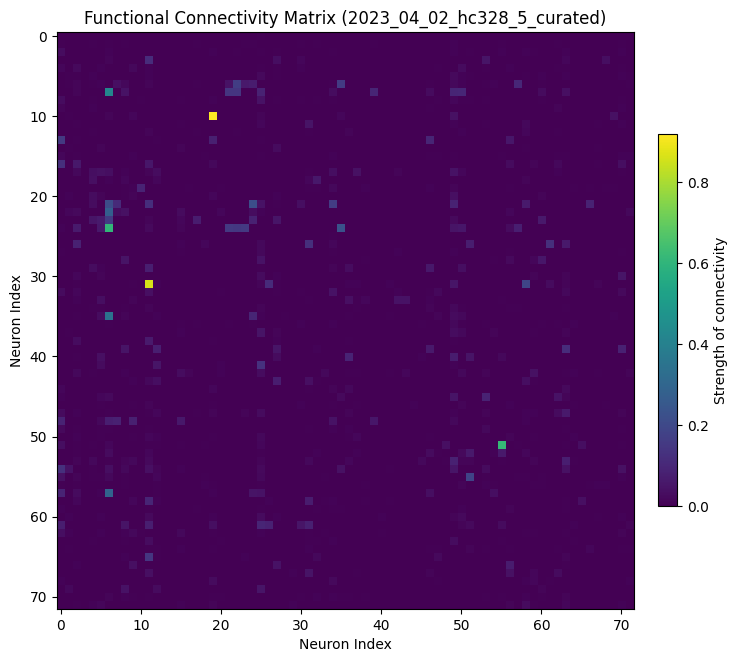

In [25]:
# Create a square figure with a shorter colorbar
fig, ax = plt.subplots(figsize=(8, 8))
heatmap = ax.imshow(FC_MAT, cmap='viridis', aspect='equal')

# Add a colorbar for better interpretation
colorbar = plt.colorbar(heatmap, fraction=0.03, pad=0.04)  # Adjust fraction and pad as needed
colorbar.set_label('Strength of connectivity')  # Add the label to the colorbar

# Adjust the layout and titles
plt.title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')

plt.show()

In [19]:
def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr=np.corrcoef( dense_raster )
    
    plt.imshow(corr)
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()

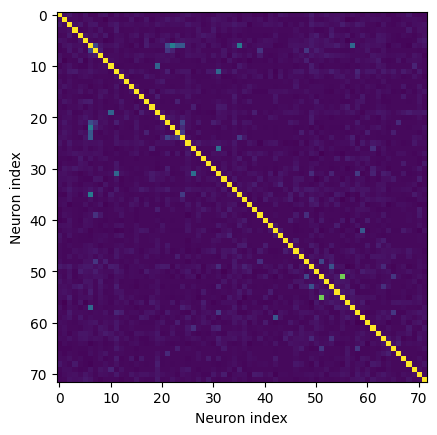

In [20]:
correlation(sd)